# Walmart data EDA

#### March 23, 2019
#### Luis Da Silva

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from joblib import dump, load

In [2]:
import sys
sys.path.insert(0, 'D:\\OneDrive\\Git\\scikit-learn-helpers')
import sklearnHelpers as skh

# Read in all data

In [3]:
features = pd.read_csv('../data/features.csv')
stores = pd.read_csv('../data/stores.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# "features" EDA

In [4]:
features.tail()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,CPI,Unemployment,IsHoliday
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,26/07/2013,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [4]:
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True)

In [6]:
features['Date'].describe()

count                    8190
unique                    182
top       2011-07-15 00:00:00
freq                       45
first     2010-02-05 00:00:00
last      2013-07-26 00:00:00
Name: Date, dtype: object

In [7]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4158
Promotion2      5269
Promotion3      4577
Promotion4      4726
Promotion5      4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

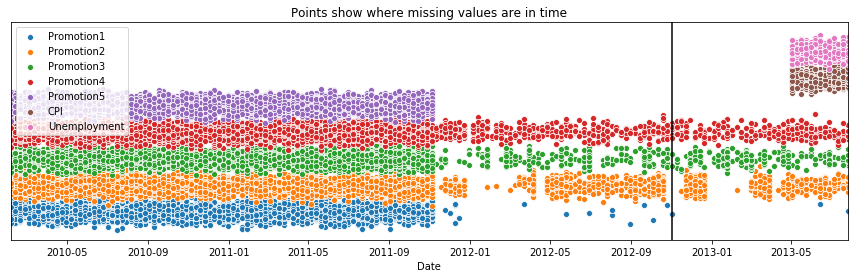

In [70]:
# Find out were missing values are
missings = features[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5',
                    'CPI', 'Unemployment']].isnull()
missings['Date'] = features['Date']
n = 0

plt.figure(figsize=(15, 4))
for v in missings.drop('Date', axis=1):
    missings[v] += n
    missings[v].replace(n, np.nan, inplace=True)
    missings[v] += np.random.normal(0, 0.2, missings.shape[0])
    sns.scatterplot(data=missings, x='Date', y=v, label=v)
    n += 1

plt.axvline(x='11-02-2012', color='black')
plt.title('Points show where missing values are in time')
plt.xlim(('2010-02-05', '2013-07-26'))
plt.legend(loc='upper left')
plt.ylabel('')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.savefig('../graphs/missingData.png')
plt.show()

In [75]:
# Average of missing values
features[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5',
                    'CPI', 'Unemployment']].isnull().mean()[:5].mean()

0.5584859584859585

In [9]:
features.describe()

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


#### Adding holidays defined as important

In [5]:
def append_holiday(df, dates, name, lag=0):
    holy = {'Date': dates}
    holy = pd.DataFrame(holy)  
    holy['Date'] = pd.to_datetime(holy['Date'])
    holy[name] = 1
    if lag != 0:
        holy['Date'] = holy['Date'].apply(lambda x: x - dt.timedelta(days=lag))
    
    df = df.merge(holy, on='Date', how='left')
    df[name].fillna(0, inplace=True)
    return df

In [6]:
dates = {'Superbowl': ('12/02/2010', '11/02/2011', '10/02/2012', '08/02/2013'),
         'Labor': ('10/09/2010', '09/09/2011', '07/09/2012', '06/09/2013'),
         'ThanksGiving': ('26/11/2010', '25/11/2011', '23/11/2012', '29/11/2013'),
         'Christmas': ('31/12/2010', '30/12/2011', "28/12/2012", '27/12/2013')}
for event, date in dates.items():
    features = append_holiday(features, date, event)
    features = append_holiday(features, date, event + '_l7', 7)
    features = append_holiday(features, date, event + '_l14', 14)
    features = append_holiday(features, date, event + '_l-7', -7)

#### Promotions EDA

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


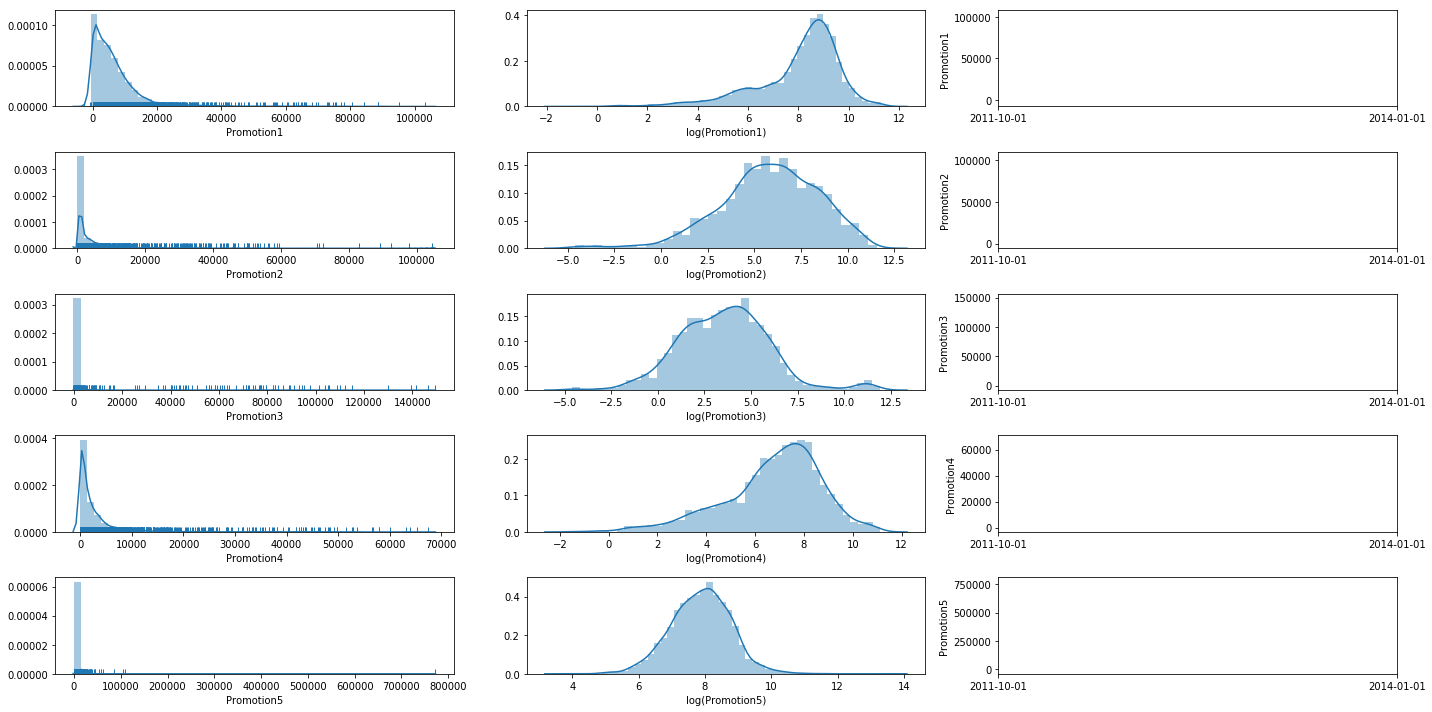

In [12]:
plt.figure(figsize=(20, 10))
for i in range(1,6):
    var = 'Promotion' + str(i)
    
    plt.subplot(5, 3, (i-1)*3+1)
    sns.distplot(features[var].dropna(), rug=True)
    
    plt.subplot(5, 3, (i-1)*3+2)
    sns.distplot(np.log(features[var].replace(0, 0.01)).dropna())
    plt.xlabel("log({})".format(var))

    plt.subplot(5, 3, i*3)
    sns.lineplot(features.index, features[var], ci=None)
    plt.xlim(['2011-10-01', '2014-01-01'])
    
plt.tight_layout()
plt.show()

In [7]:
features['Day'] = features['Date'].dt.day
features['Month'] = features['Date'].dt.month
features['Year'] = features['Date'].dt.year
features['Week'] = features['Date'].apply(lambda x: x.isocalendar()[1])
features['Date-1'] = features['Date'].apply(lambda x: x.replace(year= x.year-1))
features['Date-2'] = features['Date'].apply(lambda x: x.replace(year= x.year-2))

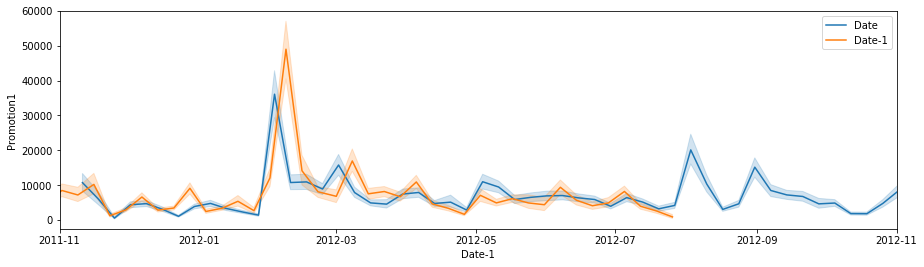

In [14]:
# Current year vs next year
plt.figure(figsize=(15,4))
for k in ['Date', 'Date-1']:
    sns.lineplot(data=features, y='Promotion1', x=k, label=k)
plt.xlim(('2011-11-01', '2012-11-01'))
plt.legend()
plt.show()

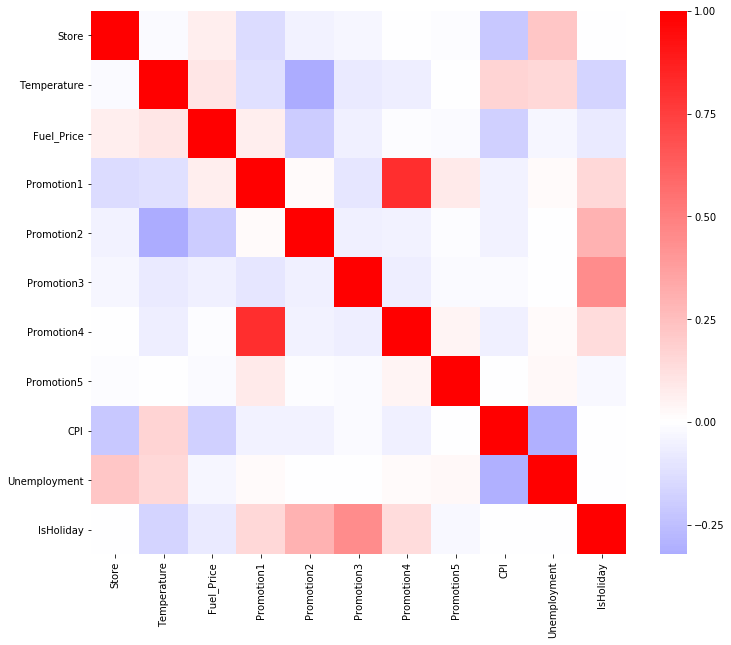

In [7]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(features.corr(), cmap='bwr', center=0)
plt.savefig('../graphs/featuresHeatmap.png')
plt.show()

In [8]:
for i in range(1,6):
    mean_promo = features.groupby('Store')['Promotion{}'.format(i)].mean()
    for p, name in ((75, 'High'), (25, 'Low')):
        p = np.percentile(mean_promo, p)
        p = pd.DataFrame(mean_promo >= p)
        p.columns = ['{}Promoter{}'.format(name, i)]
        p.reset_index(inplace=True)
        features = features.merge(p, on='Store', how='left')

#### Temperature

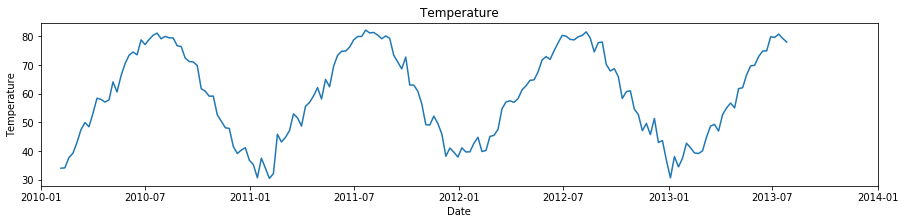

In [8]:
plt.figure(figsize=(15, 3))
sns.lineplot(features['Date'], features['Temperature'], ci=None)
plt.title('Temperature')
plt.xlim(['2010-01-01', '2014-01-01'])
plt.savefig('../graphs/temperature.png')
plt.show()

#### CPI

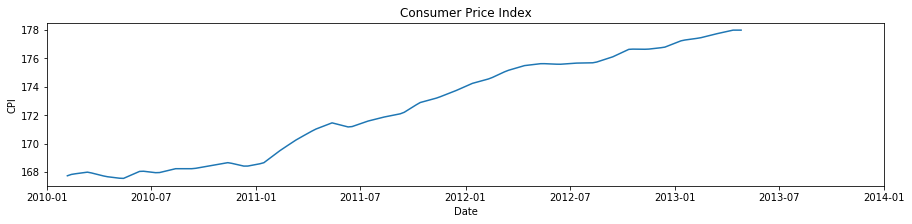

In [9]:
plt.figure(figsize=(15, 3))
sns.lineplot(features['Date'], features['CPI'], ci=None)
plt.xlim(['2010-01-01', '2014-01-01'])
plt.title('Consumer Price Index')
plt.savefig('../graphs/cpi.png')
plt.show()

In [20]:
features[features['CPI'].isnull()]['Date'].unique()

array(['2013-05-03T00:00:00.000000000', '2013-05-10T00:00:00.000000000',
       '2013-05-17T00:00:00.000000000', '2013-05-24T00:00:00.000000000',
       '2013-05-31T00:00:00.000000000', '2013-06-07T00:00:00.000000000',
       '2013-06-14T00:00:00.000000000', '2013-06-21T00:00:00.000000000',
       '2013-06-28T00:00:00.000000000', '2013-07-05T00:00:00.000000000',
       '2013-07-12T00:00:00.000000000', '2013-07-19T00:00:00.000000000',
       '2013-07-26T00:00:00.000000000'], dtype='datetime64[ns]')

#### Unemployment

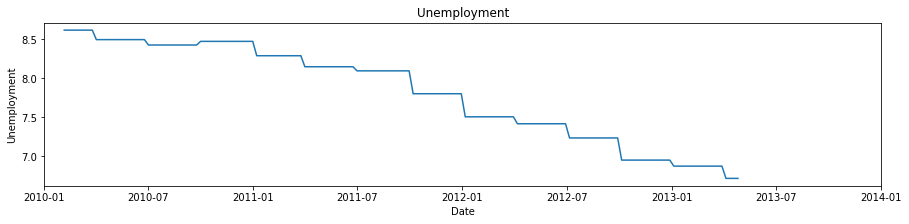

In [13]:
plt.figure(figsize=(15, 3))
sns.lineplot(features['Date'], features['Unemployment'], ci=None)
plt.xlim(['2010-01-01', '2014-01-01'])
plt.title('Unemployment')
plt.savefig('../graphs/unemployment.png')
plt.show()

# Model to fill missing values

### Now, add some predictive features

In [9]:
targets = ['Promotion{}'.format(i) for i in range(1,6)]
predictors =['Temperature', 'Fuel_Price', 'Promotion1', 'CPI', 'Unemployment', 'IsHoliday', 
             'Year', 'Month', 'ImportantHoliday'] + ['Store_{}'.format(i) for i in range(1, 46)] + \
            ['Week_{}'.format(i) for i in range(1, 53)]

In [10]:
def append_lag_price(df, promo, lag=-7):
    ndf = df.loc[:,['Date', 'Store', promo]]
    ndf2 = df[['Date', 'Store']]
    ndf['Date'] = ndf.loc[:,'Date'].apply(lambda x: x - dt.timedelta(days=lag))
    
    name = promo+str(lag)
    ndf.columns = ['Date', 'Store', name]
    return ndf2.merge(ndf, on=['Date', 'Store'], how='left')[name]

In [11]:
for i in (7, 14, 21):
    features['Promotion1'+str(i)] = append_lag_price(features, 'Promotion1', i)

In [12]:
features = pd.get_dummies(features, prefix=['Store', 'Week', 'Month'], 
                          columns=['Store', 'Week', 'Month'])

In [14]:
features['IsHoliday'] = features['IsHoliday'].astype(int)

In [13]:
features_train = features[features['Date'] >= '11-05-2011'].fillna(0)
features_predict = features[features['Date'] < '11-05-2011']

## Train Random Forest Model, predict promotions and fill missing data

In [87]:
for i in range(3,6):
    target = 'Promotion{}'.format(i)
    
    # Prepare datasets
    drop_columns = ['Promotion{}'.format(j) for j in range(1,6) if j!=i] + \
                   ['HighPromoter{}'.format(j) for j in range(1,6) if j!=i] + \
                   ['LowPromoter{}'.format(j) for j in range(1,6) if j!=i] + \
                   ['Promotion17','Promotion114','Promotion121']
    temp = features_train.drop(drop_columns, axis=1)
    temp.dropna(inplace=True)
    y = temp[target]
    X = temp.drop([target, 'Date', 'Day', 'Year', 'Date-1', 'Date-2'], axis=1)
    
    # Train model
    rf = RandomForestRegressor(n_estimators=100, max_depth=None)
    param_grid = {'n_estimators':[50], 'max_depth':[50]}
    results = skh.tune_fit_model(X, y, rf, forward_selection=True, cv=3, verbose=True,
                            scoring='neg_mean_squared_error', stopping=5, param_grid=param_grid)
    
    # Save results for later use
    tsubset = results['subset']
    dump(results, '../models/RandomForests_{}.joblib'.format(target))
    
    # Append predictions
    features_predict.loc[:,target] = results['model'].predict(features_predict[tsubset])
    print(target, 'finished.')
    print('-'*20)
    print()

# Consolidate new dataset
features = pd.concat([features_predict, features_train], sort=False)
features.to_csv('../data/Filled_features.csv')

Initializing forward selection process...
Round 1 completed in 0:00:48.276972 (0:00:48.276972 total, 1:46:12.560304 predicted).
1 features selected so far with score -39657714.805003315.
Round 2 completed in 0:00:49.270276 (0:01:37.548253 total, 1:47:18.184632 predicted).
2 features selected so far with score -18370828.58197983.
Round 3 completed in 0:00:56.020803 (0:02:33.569056 total, 1:52:37.038420 predicted).
3 features selected so far with score -10836867.950929541.
Round 4 completed in 0:01:10.572580 (0:03:44.141636 total, 2:03:16.673988 predicted).
4 features selected so far with score -10317142.644765895.
Round 5 completed in 0:01:12.566635 (0:04:56.708271 total, 2:10:33.098328 predicted).
5 features selected so far with score -9599235.275062116.
Round 6 completed in 0:03:56.381173 (0:08:53.089444 total, 3:15:27.967812 predicted).
6 features selected so far with score -9189229.05600275.
Round 7 completed in 0:03:30.424452 (0:12:23.513896 total, 3:53:40.547772 predicted).
7 feat

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Promotion3 finished.
--------------------

Initializing forward selection process...
Round 1 completed in 0:00:46.078788 (0:00:46.078788 total, 1:41:22.400016 predicted).
1 features selected so far with score -30311360.521980345.
Round 2 completed in 0:02:56.888140 (0:03:42.966928 total, 4:05:15.817248 predicted).
2 features selected so far with score -20259406.45483456.
Round 3 completed in 0:03:07.738102 (0:06:50.705030 total, 5:01:11.021364 predicted).
3 features selected so far with score -16522824.694700098.
Round 4 completed in 0:03:16.070819 (0:10:06.775849 total, 5:33:43.602984 predicted).
4 features selected so far with score -15896369.962536674.
Round 5 completed in 0:03:29.416260 (0:13:36.192109 total, 5:59:07.471704 predicted).
5 features selected so far with score -15308983.236395907.
Round 6 completed in 0:03:40.744422 (0:17:16.936531 total, 6:20:12.603660 predicted).
6 features selected so far with score -14853156.860590244.
Round 7 completed in 0:03:43.295896 (0:21:00.2

Round 57 completed in 0:08:06.778718 (5:45:11.378566 total, 13:19:23.192508 predicted).
56 features selected so far with score -12077465.62455501.
Round 58 completed in 0:09:18.449270 (5:54:29.827836 total, 13:26:47.194440 predicted).
56 features selected so far with score -12077465.62455501.
Round 59 completed in 0:07:55.877757 (6:02:25.706589 total, 13:30:51.411336 predicted).
56 features selected so far with score -12077465.62455501.
Round 60 completed in 0:07:52.765135 (6:10:18.471724 total, 13:34:40.637784 predicted).
60 features selected so far with score -12069989.469926778.
Round 61 completed in 0:07:45.433714 (6:18:03.905438 total, 13:38:06.483864 predicted).
60 features selected so far with score -12069989.469926778.
Round 62 completed in 0:07:47.464282 (6:25:51.369720 total, 13:41:30.012948 predicted).
62 features selected so far with score -12055674.596744142.
Round 63 completed in 0:07:49.226569 (6:33:40.596289 total, 13:44:50.773200 predicted).
62 features selected so far

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Promotion4 finished.
--------------------

Initializing forward selection process...
Round 1 completed in 0:00:45.282933 (0:00:45.282933 total, 1:39:37.347156 predicted).
1 features selected so far with score -168564704.58285397.
Round 2 completed in 0:00:48.252999 (0:01:33.535932 total, 1:42:53.371512 predicted).
2 features selected so far with score -167198964.429119.
Round 3 completed in 0:00:51.090423 (0:02:24.626355 total, 1:46:03.559620 predicted).
3 features selected so far with score -165912081.20923358.
Round 4 completed in 0:00:53.807151 (0:03:18.433506 total, 1:49:08.305632 predicted).
4 features selected so far with score -165128563.77995938.
Round 5 completed in 0:00:57.284848 (0:04:15.718354 total, 1:52:30.964572 predicted).
5 features selected so far with score -164196187.860439.
Round 6 completed in 0:01:05.122910 (0:05:20.841264 total, 1:57:38.507808 predicted).
6 features selected so far with score -163964654.79813477.
Round 7 completed in 0:01:05.644502 (0:06:26.4857

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Promotion5 finished.
--------------------



In [14]:
# If re-running the notebook without fitting random forests
i=4
target = 'Promotion{}'.format(i)
drop_columns = ['Promotion{}'.format(j) for j in range(1,6) if j!=i] + \
                   ['HighPromoter{}'.format(j) for j in range(1,6) if j!=i] + \
                   ['LowPromoter{}'.format(j) for j in range(1,6) if j!=i] + \
                   ['Promotion17','Promotion114','Promotion121']
temp = features_train.drop(drop_columns, axis=1)
temp.dropna(inplace=True)
y = temp[target]
X = temp.drop([target, 'Date', 'Day', 'Year', 'Date-1', 'Date-2'], axis=1)

results = load('../models/RandomForests_Promotion{}.joblib'.format(i))
tsubset = results['subset']
rf = results['model']
y_test = rf.predict(X[tsubset])

D:\Anaconda\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserW

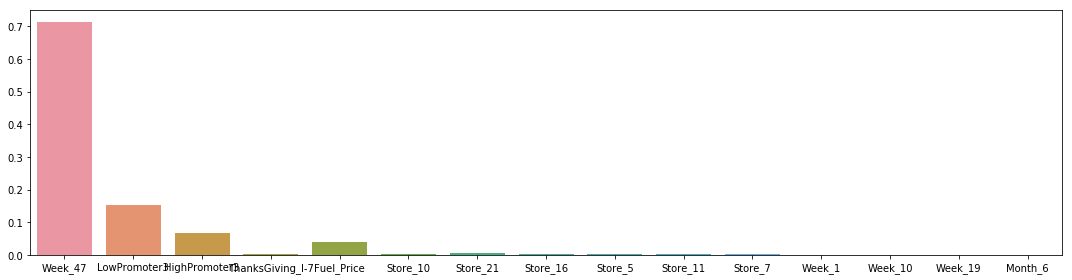

In [15]:
plt.figure(figsize=(15,4))
sns.barplot(x=tsubset, y=rf.feature_importances_)
plt.tight_layout()
plt.show()

In [22]:
filled_features = pd.read_csv('../data/Filled_features.csv').iloc[:,1:]
filled_features['Date'] = pd.to_datetime(filled_features['Date'], dayfirst=True)
filled_features = filled_features[filled_features['Date'] < '11-05-2011']
filled_features.head()

,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,CPI,Unemployment,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Store
0,2010-02-05,42.31,2.572,9539.187953,2077.0114,1.854133,45696.307550,4120.961319,211.096358,8.106,...,0,0,0,0,0,0,0,0,0,1
1,2010-02-12,38.51,2.548,13188.426082,2077.0114,1.854133,19818.465893,5430.030254,211.242170,8.106,...,0,0,0,0,0,0,0,0,0,1
2,2010-02-19,39.93,2.514,16738.279081,9348.6270,1.854133,10530.106560,5559.947421,211.289143,8.106,...,0,0,0,0,0,0,0,0,0,1
3,2010-02-26,46.63,2.561,13286.471900,5944.2550,1.854133,5925.722167,4120.961319,211.319643,8.106,...,0,0,0,0,0,0,0,0,0,1
4,2010-03-05,46.50,2.625,17220.229624,210.9458,1.854133,21217.502567,2497.842104,211.350143,8.106,...,0,0,0,0,0,0,0,0,0,1


In [25]:
np.concatenate([filled_features['Promotion3'], y_test[mask]])

array([2792.58218   ,  770.26892222,  210.6563    , ...,  189.46891631,
         70.31194315,  158.6542    ])

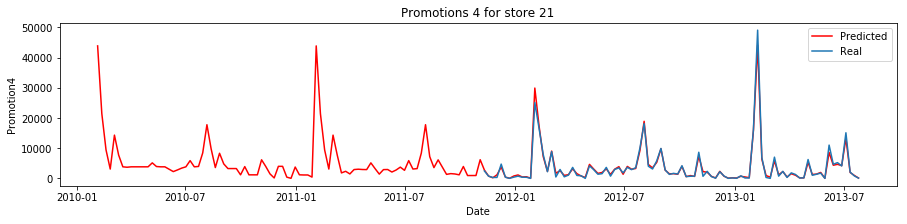

In [47]:
plt.figure(figsize=(15,3))
n = '21'
i = 4
mask = temp['Store_'+n] == 1
mask2 = features_train['Store_'+n] == 1
mask3 = filled_features['Store_'+n] == 1

y_to_plot = np.concatenate([filled_features[mask3]['Promotion'+str(i)], y_test[mask]])
date_to_plot = np.concatenate([filled_features[mask3]['Date'], temp['Date'][mask]])

sns.lineplot(date_to_plot, y_to_plot, label='Predicted', color='red')
sns.lineplot(features_train['Date'][mask2], features_train['Promotion'+str(i)][mask2], label='Real')
#plt.xlim(('2011-12-01', '2013-04-01'))
plt.title('Promotions {} for store {}'.format(i, n))
plt.legend()
plt.savefig('../graphs/promotions{}Store{}'.format(i,n))
plt.show()

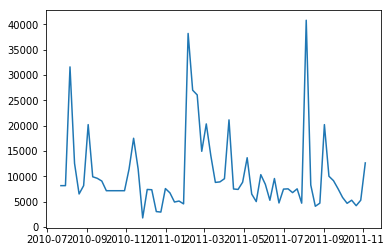

In [75]:
mask = features_predict['Store'] == 'Store_25'
plt.plot(features_predict.loc[:,'Date'][mask], features_predict.loc[:,'Promotion1'][mask])
plt.show()

In [121]:
features['Store'] = features['Store_1']
for i in range(2,46):
    features.loc[features['Store_{}'.format(i)]==1,'Store'] = i
features.to_csv('../data/Filled_features.csv')

In [82]:
np.percentile(train.Weekly_Sales, (1, 50, 75, 9, 95, 99))

array([5.00000000e+00, 7.61203000e+03, 2.02058525e+04, 2.26000000e+02,
       6.12019510e+04, 1.06479586e+05])

# "stores" EDA

In [127]:
stores.head()

,Store,Type,Size (sq ft)
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [128]:
stores.isnull().sum()

Store           0
Type            0
Size (sq ft)    0
dtype: int64

In [129]:
stores.shape

(45, 3)

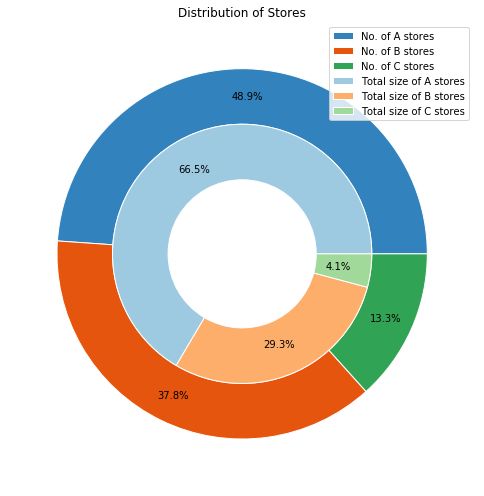

In [25]:
fig, ax = plt.subplots(figsize = (7, 7))

size = 0.3
counts =stores['Type'].value_counts()
sizes = stores.groupby('Type').sum()['Size (sq ft)']
count_labels = ["No. of {} stores".format(k) for k in stores['Type'].unique()]
sizes_labels = ["Total size of {} stores".format(k) for k in stores['Type'].unique()]

cmap = plt.get_cmap("tab20c")
outer_colors = cmap([0, 4, 8])
inner_colors = cmap([2, 6, 10])

ax.pie(counts, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),
       autopct='%1.1f%%', pctdistance=0.85)

ax.pie(sizes, radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),
       autopct='%1.1f%%', pctdistance=0.75)

ax.set(aspect="equal", title='Distribution of Stores')
plt.legend(count_labels + sizes_labels)
plt.tight_layout()
plt.savefig('../graphs/distributionStores.png')
plt.show()

In [107]:
mask = stores['Size (sq ft)']<50000
stores[mask].sort_values('Size (sq ft)')

,Store,Type,Size (sq ft)
4,5,B,34875
2,3,B,37392
32,33,A,39690
37,38,C,39690
41,42,C,39690
35,36,A,39910
36,37,C,39910
43,44,C,39910
42,43,C,41062
29,30,C,42988


D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


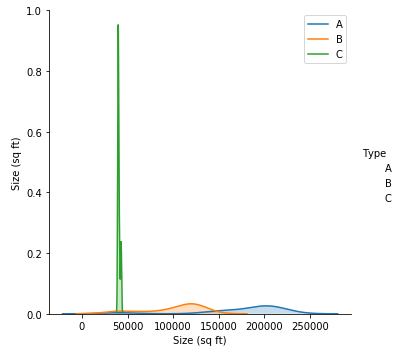

In [131]:
sns.pairplot(stores.loc[:,['Type', 'Size (sq ft)']], hue='Type', height=5)
plt.legend()
plt.show()

# "train" EDA

In [27]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [4]:
train['Date'] = pd.to_datetime(train['Date'], dayfirst = True)

In [8]:
train.shape

(421570, 4)

In [110]:
train.groupby(['Store', 'Dept']).IsHoliday.sum().max()

10.0

In [9]:
train.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [134]:
train['IsHoliday'].mean()

0.07035842208885831

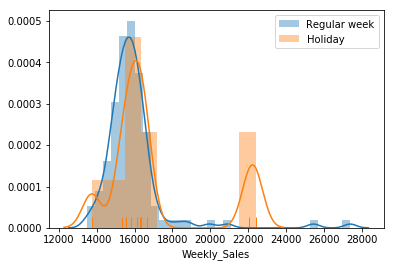

In [113]:
train_per_week = train.groupby('Date').mean()
sns.distplot(train_per_week[~train_per_week['IsHoliday']]['Weekly_Sales'], label='Regular week')
sns.distplot(train_per_week[train_per_week['IsHoliday']]['Weekly_Sales'], rug=True, label='Holiday')
plt.legend()
plt.savefig('../graphs/holidayDist.png')
plt.show()

In [115]:
train['ImportantHoliday'] = np.logical_and(train['Weekly_Sales'] > 19000, train['IsHoliday'])

In [117]:
train[train['ImportantHoliday']].Date.unique()

array(['2010-02-12T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-11-25T00:00:00.000000000',
       '2011-12-30T00:00:00.000000000', '2012-02-10T00:00:00.000000000',
       '2010-09-10T00:00:00.000000000', '2010-11-26T00:00:00.000000000',
       '2011-09-09T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [5]:
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Week'] = train.Date.dt.week
train['Year'].unique()

array([2010, 2011, 2012], dtype=int64)

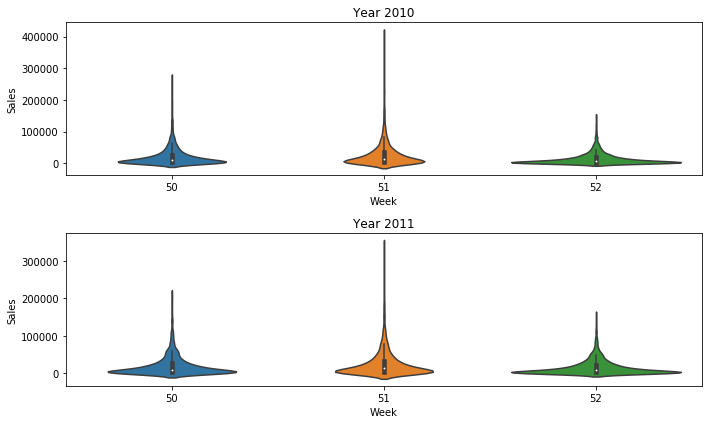

In [60]:
nyear = train['Year'].nunique()
plt.figure(figsize=(10,6))
for i, year in enumerate(train['Year'].unique()):
    if i == nyear-1:
        break
    plt.subplot(nyear - 1, 1, i+1)
    mask = np.logical_and(train['Week'] >= 50, train['Year'] == year)
    sns.violinplot(data=train[mask], y='Weekly_Sales', x='Week')
    plt.ylabel('Sales')
    plt.title('Year {}'.format(year))

plt.tight_layout()
plt.savefig('../graphs/christmasPerYear.png')
plt.show()

In [89]:
bydept = pd.pivot_table(data=train, index='Date', columns='Dept', values='Weekly_Sales', aggfunc='mean')

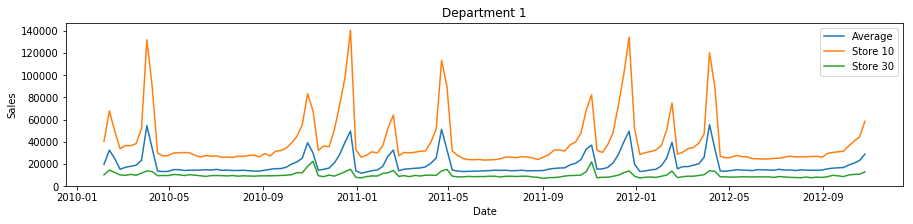

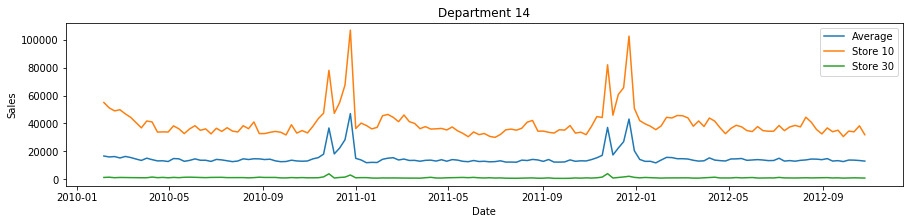

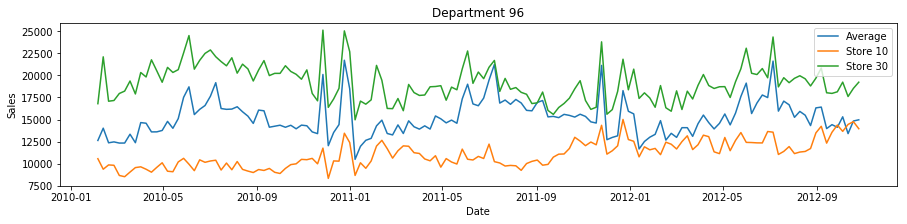

In [91]:
for i in (1, 14, 96):
    mask_a = np.logical_and(train['Store'] == 10, train['Dept'] == i)
    mask_b = np.logical_and(train['Store'] == 30, train['Dept'] == i)
    plt.figure(figsize=(15,3))
    sns.lineplot(data=bydept, x=bydept.index, y=i, label='Average')
    sns.lineplot(data=train[mask_a], x='Date', y='Weekly_Sales', label='Store 10')
    sns.lineplot(data=train[mask_b], x='Date', y='Weekly_Sales', label='Store 30')
    plt.ylabel('Sales')
    plt.title('Department '+str(i))
    plt.legend()
    plt.savefig('../graphs/avgDept{}.png'.format(i))
    plt.show()

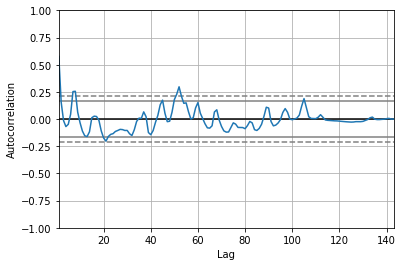

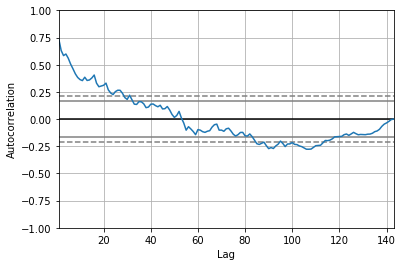

In [67]:
for i in (1, 96):
    mask = np.logical_and(train['Store'] == 10, train['Dept'] == i)
    pd.plotting.autocorrelation_plot(train[mask]['Weekly_Sales'])
    plt.show()

In [58]:
sales_size = train.merge(stores, on='Store')
sales_size['SalesSize'] = sales_size['Weekly_Sales']/sales_size['Size (sq ft)']*52

In [50]:
sales_sqft = sales_size.groupby('Type')['SalesSize'].median()*52
sales_store = sales_size.groupby('Type')['Weekly_Sales'].median()*52

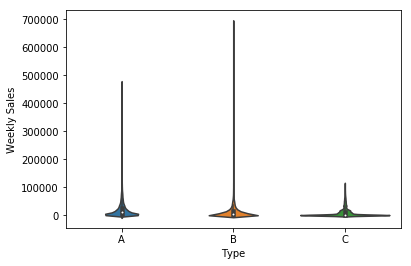

In [59]:
sns.violinplot(data=sales_size, x='Type', y='Weekly_Sales')
plt.ylabel('Weekly Sales')
plt.savefig('../graphs/weeklySales.png')

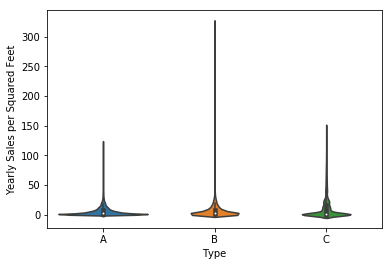

In [60]:
sns.violinplot(data=sales_size, x='Type', y='SalesSize')
plt.ylabel('Yearly Sales per Squared Feet')
plt.savefig('../graphs/yearlySalesSqf.png')

# "Test"

In [137]:
test['Date'] = pd.to_datetime(test['Date'], dayfirst = True)

In [11]:
test.Date.describe()

count                  115064
unique                     39
top       2012-12-21 00:00:00
freq                     3002
first     2012-11-02 00:00:00
last      2013-07-26 00:00:00
Name: Date, dtype: object

In [13]:
test.shape

(115064, 5)

In [14]:
test.isnull().sum()

Store                                0
Dept                                 0
Date                                 0
IsHoliday                            0
Weekly_Sales to be predicted    115064
dtype: int64

In [61]:
test.Date.nunique()

39

# Merging

In [138]:
data = {}
for n, df in (('train', train), ('test', test)):
    df = df.merge(features.drop('IsHoliday', axis=1), on=['Date', 'Store'])
    df = df.merge(stores, on='Store')
    df.to_csv('../data/merged_{}_data.csv'.format(n))
    print(df.shape)
    data[n] = df

(421570, 159)
(115064, 158)


In [ ]:
data['train'].head()

In [ ]:
plt.figure(figsize=(7, 6))
sns.heatmap(data['train'].loc[:,'Weekly_Sales':].corr(), cmap='bwr', center=0)
plt.title("Full Train Dataset correlation heatmap")
plt.show()